In [1]:
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.models import Model
from keras.preprocessing import image
from keras import models
from keras import layers
from keras import optimizers

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import sys
import os

from PIL import Image

from dotenv import load_dotenv

In [3]:
sys.path.append("../Library/")
import deep_learning as dl
import image_manipulation as ima
import machine_learning as ml

In [4]:
%load_ext autoreload
%autoreload 2

## Data augmentation

In [ ]:
image.ImageDataGenerator

# Load ResNet with 50 Layers

In [5]:
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape = (512, 512, 3))

Instructions for updating:
Colocations handled automatically by placer.


/Users/peterweber/Programs/anaconda2/envs/tensorflow/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [6]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

# Image Pipeline Testground

### Test Image

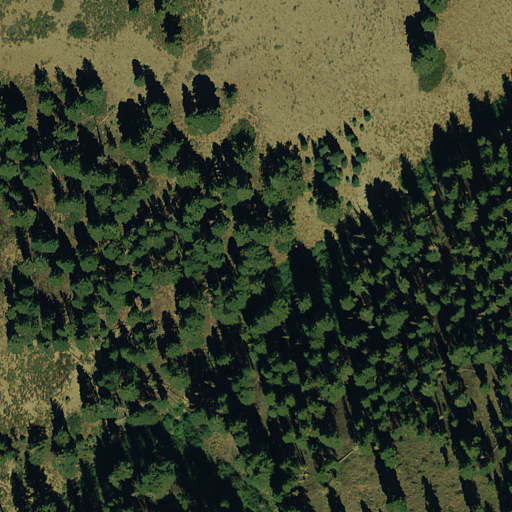

In [7]:
path = "/Users/peterweber/Google Drive/MFP - Satellogic/images/usgs_512_res0.3m/forest-woodland/label_0/11skd505425_x3268_y1220_size512_baseres0.3m.png"
test_image = image.load_img(path, target_size = (512, 512))
test_image

### Plot Filter Activations of the 2nd Convolutional Layer

In [8]:
activation = dl.get_activations(test_image, base_model, 49)

Shape of input: (1, 512, 512, 3)
Shape of output: (1, 16, 16, 2048)


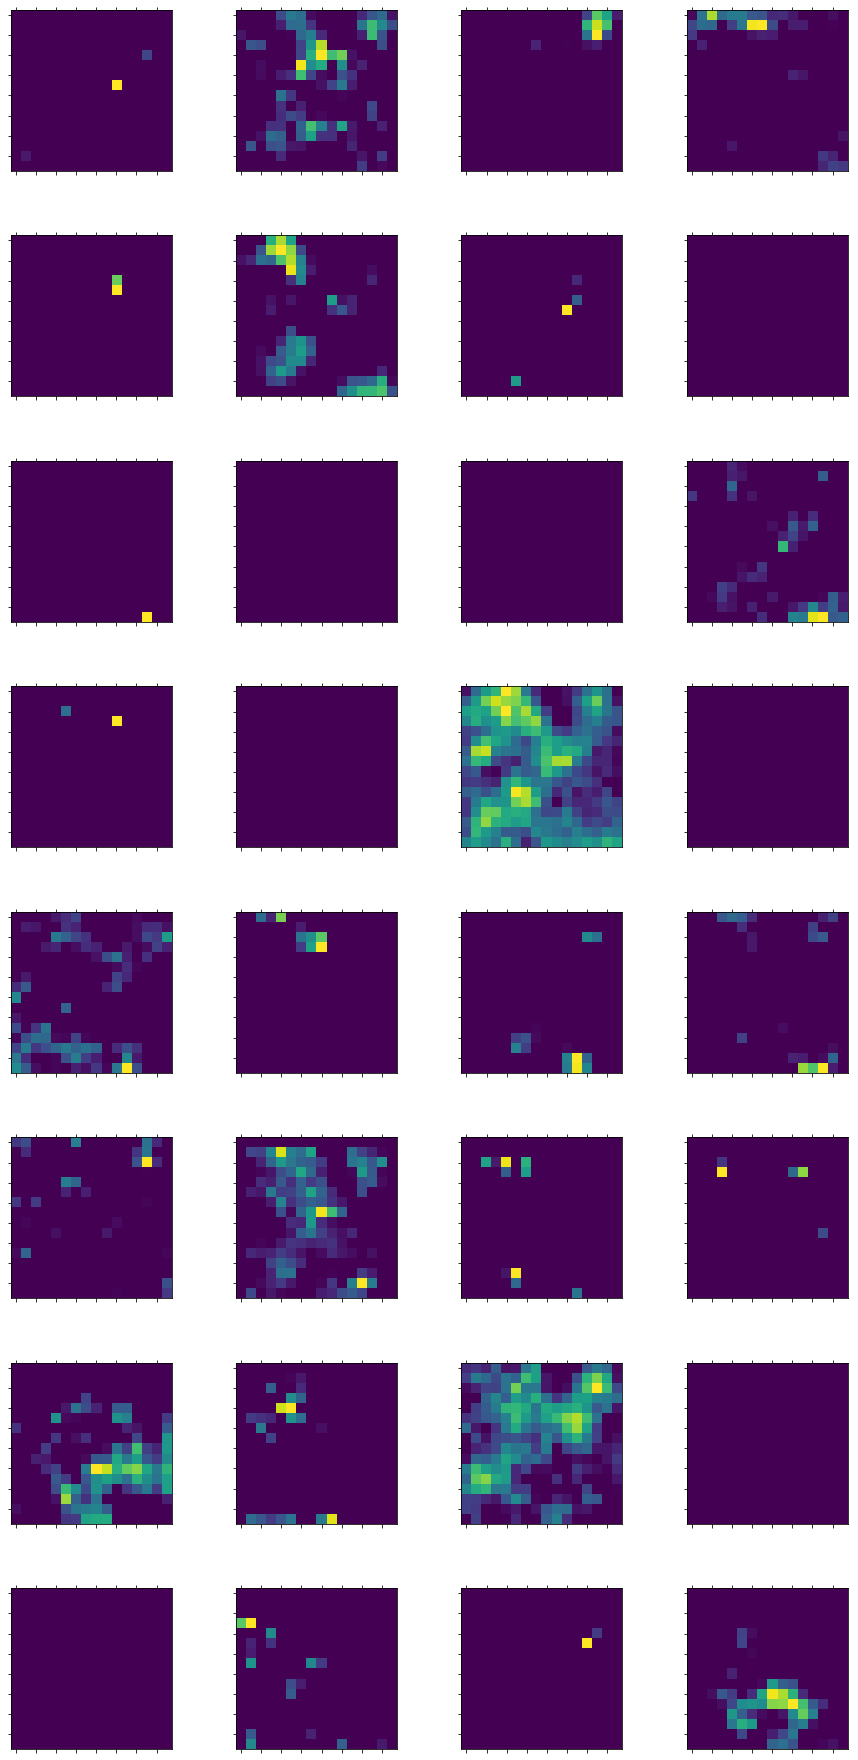

In [9]:
num_filters = 32# activation.shape[3]
columns = 4

fig = plt.figure(figsize=(15, 4*num_filters/columns))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, num_filters + 1):
    ax = fig.add_subplot(int(num_filters/columns), columns, i)
    ax.matshow(activation[0, :, :, i-1], cmap='viridis')

    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])

# Load Image Batch

### Define degraded resolutions and image sizes for later use

In [10]:
sizes = {}
base_res = 0.3
base_size = 512
for factor in range(2, 11):
    res = round(base_res * factor,1)
    size = round(base_size/factor)
    sizes[res] = (size, size)
print("\nSizes dictionary:\n", sizes)


Sizes dictionary:
 {0.6: (256, 256), 0.9: (171, 171), 1.2: (128, 128), 1.5: (102, 102), 1.8: (85, 85), 2.1: (73, 73), 2.4: (64, 64), 2.7: (57, 57), 3.0: (51, 51)}


### Load Image Batch into DataFrame

In [11]:
base_folder = "/Users/peterweber/Google Drive/MFP - Satellogic/images/usgs_512_res0.3m"
categories = ["forest-woodland", "agriculture", "shrubland-grassland", "semi-desert"]
labels = [0, 1, 2]

df_images = pd.DataFrame(columns = ['filename', 'image', 'resolution', 'label', 'category'])
for category in categories:
    for label in labels:
        df = ima.load_images_into_df_by_category_and_label(base_folder, category, label)
        df_images = df_images.append(df)    

In [14]:
print("Shape of df_images:", df_images.shape)
print("Distribution of categories and labels:\n", df_images.groupby(['category', 'label']).size().reset_index(name='counts'))
print("\nDistribution of labels:\n", df_images.groupby(['label']).size().reset_index(name='counts'))

Shape of df_images: (963, 5)
Distribution of categories and labels:
               category  label  counts
0          agriculture      2     210
1      forest-woodland      0     187
2      forest-woodland      1      34
3      forest-woodland      2      37
4          semi-desert      0      86
5          semi-desert      1       8
6          semi-desert      2      51
7  shrubland-grassland      0     170
8  shrubland-grassland      1      61
9  shrubland-grassland      2     119

Distribution of labels:
    label  counts
0      0     443
1      1     103
2      2     417


In [15]:
df_images.head()

,filename,image,resolution,label,category
0,11skd505320_x1732_y708_size512_baseres0.3m.png,"[[[64, 91, 53], [68, 95, 53], [72, 95, 51], [6...",0.3,0,forest-woodland
1,11skd505395_x2756_y2244_size512_baseres0.3m.png,"[[[86, 74, 38], [75, 56, 37], [3, 30, 22], [56...",0.3,0,forest-woodland
2,17sku865490_x4292_y2756_size512_baseres0.3m.png,"[[[96, 123, 102], [99, 123, 103], [95, 116, 96...",0.3,0,forest-woodland
3,16tcs735720_x132_y3204_size512_baseres0.3m.png,"[[[43, 52, 56], [41, 51, 57], [42, 53, 60], [4...",0.3,0,forest-woodland
4,11skd505425_x2244_y708_size512_baseres0.3m.png,"[[[150, 117, 70], [140, 125, 81], [145, 140, 9...",0.3,0,forest-woodland


### Enhance Images DataFrame by Degraded Images

In [17]:
df_degraded = ima.load_degraded_images_into_df(df_images, sizes, label = True)

df_images = df_images.append(df_degraded)
print("Shape of df_images:", df_images.shape)
print(df_degraded.sample(frac=1).head())
del df_degraded

Shape of df_images: (96300, 5)
                  category                                         filename  \
71785  shrubland-grassland       118082_x2756_y2756_size512_baseres0.3m.png   
31942      forest-woodland   11skd505425_x708_y2244_size512_baseres0.3m.png   
62592          semi-desert   12tvk065820_x196_y1732_size512_baseres0.3m.png   
24787  shrubland-grassland  17rnk145115_x1732_y1732_size512_baseres0.3m.png   
12132  shrubland-grassland    5343dd-26_x3744_y6816_size512_baseres0.3m.png   

                                                   image label  resolution  
71785  [[[63, 57, 49], [59, 58, 50], [58, 61, 51], [5...     0         2.7  
31942  [[[33, 46, 33], [24, 44, 33], [54, 76, 44], [6...     0         1.5  
62592  [[[51, 67, 45], [50, 64, 45], [86, 89, 63], [1...     2         2.4  
24787  [[[136, 138, 126], [130, 131, 116], [118, 117,...     2         1.2  
12132  [[[97, 113, 100], [100, 116, 103], [104, 122, ...     0         0.9  


### Generate data set X and y that can be fed into an ML algorithm

In [19]:
RESOLUTION = 0.3

X, y = dl.generate_X_y_from_df(df_images, RESOLUTION)

Shape of image array is: (162, 512, 512, 3)


### Extract Convolutional Net Activations for Image Batch

In [20]:
X = dl.get_activations(X, base_model, activation = 2)

Shape of input: (162, 512, 512, 3)
Shape of output: (162, 128, 128, 64)


# Next: 
### option 1
Feed Activations of ResNet into Fully Connected Network

### option 2
Feed Activations of ResNet into any other classifier